In [2]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from VQ_VAE_model import VQ,E_distance,VQVAE,Embediing_layer

parser = argparse.ArgumentParser(description='VAE MNIST Example')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='enables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--emb-dim', default=500, type=int)
parser.add_argument('--emb-num', default=10, type=int)
parser.add_argument('--beta', default=0.25, type=float)

args = parser.parse_args(args=[])
args.cuda = not args.no_cuda and torch.cuda.is_available()


torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)


kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, **kwargs)




In [3]:


vqvae = VQVAE(args.emb_dim, args.emb_num)
if args.cuda:
    vqvae.cuda()

optimizer = optim.Adam(vqvae.parameters(), lr=1e-3)



In [4]:
def get_loss(data, vqvae):
    recon_data = vqvae(data)

    # reconstruction loss
    reconst_loss = F.binary_cross_entropy(recon_data, data)

    # cluster assignment loss
    detach_z_q = Variable(vqvae.z_q.data, requires_grad=False)
    cls_assg_loss = torch.sum((vqvae.z_e - detach_z_q).pow(2))
    cls_assg_loss /= args.batch_size

    # cluster update loss
    detach_z_e = Variable(vqvae.z_e.data, requires_grad=False)
    z_q = vqvae.layer(detach_z_e)
    cls_dist_loss = torch.sum((detach_z_e - z_q).pow(2))
    cls_dist_loss /= args.batch_size

    return reconst_loss, cls_assg_loss, cls_dist_loss

def train(epoch):
    vqvae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        data = data.view(-1, 784)
        if args.cuda:
            data = data.cuda()

        # get losses
        reconst_loss, cls_assg_loss, cls_dist_loss = get_loss(data, vqvae)

        optimizer.zero_grad()
        # get grad for dec and enc
        loss = reconst_loss + args.beta * cls_assg_loss
        loss.backward()

        # clear the grads in vqlayer because they are not grads for updating emb
        vqvae.layer.emb.zero_grad()
        # cluster update loss
        cls_dist_loss.backward() # get grad in emb
        loss += cls_dist_loss

        # all grads good. Update
        optimizer.step()
        train_loss += loss.data[0]
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data[0] / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
def test(epoch):
    vqvae.eval()
    test_loss = 0
    for i, (data, _) in enumerate(test_loader):
        if args.cuda:
            data = data.cuda()
        data = Variable(data, volatile=True)
        data = data.view(-1, 784)

        reconst_loss, cls_assg_loss, cls_dist_loss = get_loss(data, vqvae)
        test_loss += \
            (reconst_loss + args.beta*cls_assg_loss + cls_dist_loss).data[0]

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


In [5]:
for epoch in range(1, args.epochs + 1):
    train(epoch)
    test(epoch)

    # sample from each of discrete vector
    
    samples = vqvae.sample_from_modes()
    print (samples.data.view(args.emb_num, 1, 28, 28))
    
    save_image(samples.data.view(args.emb_num, 1, 28, 28),
               '/Users/tangjiaqi/Downloads/sample_'+ str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 4.450305
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.651962
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.386080
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.294798
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.225313
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.209036
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.172693
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.203026
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.158017
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.139585
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.125459
Train Epoch: 1 [14080/60000 (23%)]	Loss: 0.111927
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.081161
Train Epoch: 1 [16640/60000 (28%)]	Loss: 0.077838
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.064036
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.065615
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.064956
Train Epoch: 1 [21760/60000 (36%)]	Loss: 0.054067
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.046697
Train Epoch: 1 [24320/60000 (41%)]	Loss: 0.047687
Train Epoch: 1 [

Train Epoch: 3 [1280/60000 (2%)]	Loss: 0.003826
Train Epoch: 3 [2560/60000 (4%)]	Loss: 0.003869
Train Epoch: 3 [3840/60000 (6%)]	Loss: 0.003679
Train Epoch: 3 [5120/60000 (9%)]	Loss: 0.003623
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.003479
Train Epoch: 3 [7680/60000 (13%)]	Loss: 0.003631
Train Epoch: 3 [8960/60000 (15%)]	Loss: 0.004069
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.003811
Train Epoch: 3 [11520/60000 (19%)]	Loss: 0.003965
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.003414
Train Epoch: 3 [14080/60000 (23%)]	Loss: 0.004113
Train Epoch: 3 [15360/60000 (26%)]	Loss: 0.004673
Train Epoch: 3 [16640/60000 (28%)]	Loss: 0.003780
Train Epoch: 3 [17920/60000 (30%)]	Loss: 0.003624
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.007089
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.007218
Train Epoch: 3 [21760/60000 (36%)]	Loss: 0.003769
Train Epoch: 3 [23040/60000 (38%)]	Loss: 0.004320
Train Epoch: 3 [24320/60000 (41%)]	Loss: 0.003852
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.004276
Train Epoch

Train Epoch: 5 [1280/60000 (2%)]	Loss: 0.004628
Train Epoch: 5 [2560/60000 (4%)]	Loss: 0.002834
Train Epoch: 5 [3840/60000 (6%)]	Loss: 0.003451
Train Epoch: 5 [5120/60000 (9%)]	Loss: 0.002784
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.002791
Train Epoch: 5 [7680/60000 (13%)]	Loss: 0.002871
Train Epoch: 5 [8960/60000 (15%)]	Loss: 0.002976
Train Epoch: 5 [10240/60000 (17%)]	Loss: 0.003554
Train Epoch: 5 [11520/60000 (19%)]	Loss: 0.002766
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.003003
Train Epoch: 5 [14080/60000 (23%)]	Loss: 0.002963
Train Epoch: 5 [15360/60000 (26%)]	Loss: 0.002952
Train Epoch: 5 [16640/60000 (28%)]	Loss: 0.002954
Train Epoch: 5 [17920/60000 (30%)]	Loss: 0.002677
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.002599
Train Epoch: 5 [20480/60000 (34%)]	Loss: 0.003094
Train Epoch: 5 [21760/60000 (36%)]	Loss: 0.003953
Train Epoch: 5 [23040/60000 (38%)]	Loss: 0.002905
Train Epoch: 5 [24320/60000 (41%)]	Loss: 0.002926
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.002857
Train Epoch

Train Epoch: 7 [1280/60000 (2%)]	Loss: 0.005559
Train Epoch: 7 [2560/60000 (4%)]	Loss: 0.004841
Train Epoch: 7 [3840/60000 (6%)]	Loss: 0.003021
Train Epoch: 7 [5120/60000 (9%)]	Loss: 0.003002
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.004009
Train Epoch: 7 [7680/60000 (13%)]	Loss: 0.003852
Train Epoch: 7 [8960/60000 (15%)]	Loss: 0.003142
Train Epoch: 7 [10240/60000 (17%)]	Loss: 0.002594
Train Epoch: 7 [11520/60000 (19%)]	Loss: 0.002630
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.002613
Train Epoch: 7 [14080/60000 (23%)]	Loss: 0.002442
Train Epoch: 7 [15360/60000 (26%)]	Loss: 0.002438
Train Epoch: 7 [16640/60000 (28%)]	Loss: 0.002639
Train Epoch: 7 [17920/60000 (30%)]	Loss: 0.002493
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.002689
Train Epoch: 7 [20480/60000 (34%)]	Loss: 0.002909
Train Epoch: 7 [21760/60000 (36%)]	Loss: 0.002422
Train Epoch: 7 [23040/60000 (38%)]	Loss: 0.002639
Train Epoch: 7 [24320/60000 (41%)]	Loss: 0.002525
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.002704
Train Epoch

Train Epoch: 9 [1280/60000 (2%)]	Loss: 0.002400
Train Epoch: 9 [2560/60000 (4%)]	Loss: 0.002317
Train Epoch: 9 [3840/60000 (6%)]	Loss: 0.002289
Train Epoch: 9 [5120/60000 (9%)]	Loss: 0.002273
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.002413
Train Epoch: 9 [7680/60000 (13%)]	Loss: 0.002610
Train Epoch: 9 [8960/60000 (15%)]	Loss: 0.002358
Train Epoch: 9 [10240/60000 (17%)]	Loss: 0.002364
Train Epoch: 9 [11520/60000 (19%)]	Loss: 0.002701
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.002810
Train Epoch: 9 [14080/60000 (23%)]	Loss: 0.002350
Train Epoch: 9 [15360/60000 (26%)]	Loss: 0.002582
Train Epoch: 9 [16640/60000 (28%)]	Loss: 0.002511
Train Epoch: 9 [17920/60000 (30%)]	Loss: 0.002351
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.002612
Train Epoch: 9 [20480/60000 (34%)]	Loss: 0.002692
Train Epoch: 9 [21760/60000 (36%)]	Loss: 0.003021
Train Epoch: 9 [23040/60000 (38%)]	Loss: 0.002738
Train Epoch: 9 [24320/60000 (41%)]	Loss: 0.002843
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.002562
Train Epoch

In [8]:
from PIL import Image
jpgfile = Image.open('/Users/tangjiaqi/Downloads/sample_'+ str(epoch) + '.png')

print (jpgfile.size, jpgfile.format)

(242, 62) PNG


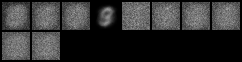

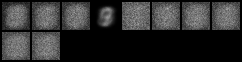

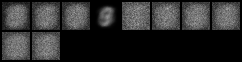

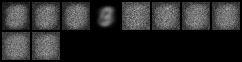

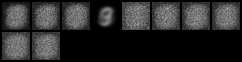

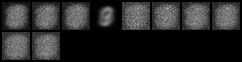

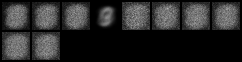

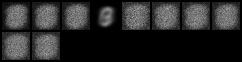

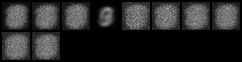

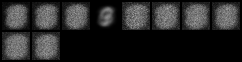

In [13]:
from IPython.display import Image, display
listOfImageNames=[]
for epoch in range(1, args.epochs + 1):
    listOfImageNames.append('/Users/tangjiaqi/Downloads/sample_'+ str(epoch) + '.png')

for imageName in listOfImageNames:
    display(Image(filename=imageName))